## Predicting Credit Default and assessing the role of 'Gender' in the process

# Open questions to business experts?

1. Is there some value in getting the Customer IDs (CURRENT ID and OLD SYSTEM ID) ?
2. What education levels do 4=others, 5,6=unknown in EDUCATION denote?
3. What marital status does 3=others in MARRIAGE denote?
4. How do we interpret PAY_* and BILL_AMT* and PAY_AMT*, and how do they collective express a good/bad behavior? eg. Are we looking for consistent payments etc.?
5. Could we have more customers to predict. The current number of customers = 2 and looks quite less to arrive on model performance?
6. Some models are having a great Recall measure but poor Precision measure and vice-versa. Which one do we choose for our problem?

# Other technical questions:
1. How do we want to deal with Outliers, especially if they form 10% of the data
2. 

In [1]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats # To use Z-score for outlier detection
import seaborn as sns
from scipy.stats import chisquare, chi2_contingency #For chi-squared correlation detection

from collections import Counter
import math
import scipy.stats as ss

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer

In [2]:
# Importing data
path = r'/global/project/queens-mma/shared/Ks/Untitled Folder/'
df = pd.read_excel(path + 'data.xlsx')
df_pred = pd.read_excel(path + 'data pred.xlsx')

In [3]:
# Checking the balance of the dataset - default.payment.next.month
df['default.payment.next.month'].value_counts()

0    11494
1     3506
Name: default.payment.next.month, dtype: int64

## We do see that this is an imbalanced dataset - True Positives(Customers that default) are only ~25% 

In [4]:
# Checking how many males vs females are there in the dataset
df['SEX'].value_counts()

1    11888
2     3112
Name: SEX, dtype: int64

## We do see that the data is also imbalanced in a Gender bias sense that the Male: Female ratio is 11888:3112

In [5]:
# Checking how many unique EDUCATION categories are there - Unordered Categorical
df['EDUCATION'].value_counts()

2    6875
1    5416
3    2489
5     129
4      53
6      27
0      11
Name: EDUCATION, dtype: int64

In [6]:
# Checking how many unique MARRIAGE categories are there - Unordered Categorical
df['MARRIAGE'].value_counts()

2    8146
1    6668
3     167
0      19
Name: MARRIAGE, dtype: int64

In [7]:
# Checking structure of dataset columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 26 columns):
CURRENT ID                    15000 non-null int64
OLD SYSTEM ID                 15000 non-null int64
LIMIT_BAL                     15000 non-null float64
SEX                           15000 non-null int64
EDUCATION                     15000 non-null int64
MARRIAGE                      15000 non-null int64
AGE                           15000 non-null int64
PAY_0                         15000 non-null int64
PAY_2                         15000 non-null int64
PAY_3                         15000 non-null int64
PAY_4                         15000 non-null int64
PAY_5                         15000 non-null int64
PAY_6                         15000 non-null int64
BILL_AMT1                     15000 non-null float64
BILL_AMT2                     15000 non-null float64
BILL_AMT3                     15000 non-null float64
BILL_AMT4                     15000 non-null float64
BILL_AMT5     

In [8]:
# Drop the ID columns as they are not required
df.drop(labels = ['CURRENT ID','OLD SYSTEM ID'], axis = 1, inplace = True)
df_pred.drop(labels = ['CURRENT ID','OLD SYSTEM ID'], axis = 1, inplace = True)

# Convert the required columns to Categorical as we know they should be Categorical
df['SEX'] = df['SEX'].astype('category', ordered = False)
df_pred['SEX'] = df_pred['SEX'].astype('category', ordered = False)
# Could have used the construct ser.astype('category', ordered=True, categories=[2, 1]) because education is 'ordered' categorical
# But, since we did not have clarity on values = 4,5,6 we used unordered categorical
df['EDUCATION'] = df['EDUCATION'].astype('category', ordered = False)
df_pred['EDUCATION'] = df_pred['EDUCATION'].astype('category', ordered = False)
# Similarly, for MARRIAGE, the value = 3 was not clear, so used unordered cateorical
df['MARRIAGE'] = df['MARRIAGE'].astype('category', ordered = False)
df_pred['MARRIAGE'] = df_pred['MARRIAGE'].astype('category', ordered = False)
df['default.payment.next.month'] = df['default.payment.next.month'].astype('category', ordered = False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
LIMIT_BAL                     15000 non-null float64
SEX                           15000 non-null category
EDUCATION                     15000 non-null category
MARRIAGE                      15000 non-null category
AGE                           15000 non-null int64
PAY_0                         15000 non-null int64
PAY_2                         15000 non-null int64
PAY_3                         15000 non-null int64
PAY_4                         15000 non-null int64
PAY_5                         15000 non-null int64
PAY_6                         15000 non-null int64
BILL_AMT1                     15000 non-null float64
BILL_AMT2                     15000 non-null float64
BILL_AMT3                     15000 non-null float64
BILL_AMT4                     15000 non-null float64
BILL_AMT5                     15000 non-null float64
BILL_AMT6                     15000 non-null float64
P

In [9]:
# Checking null values in the data
print(df.isnull().sum().sum())
print(df_pred.isnull().sum().sum())

0
0


No null values found

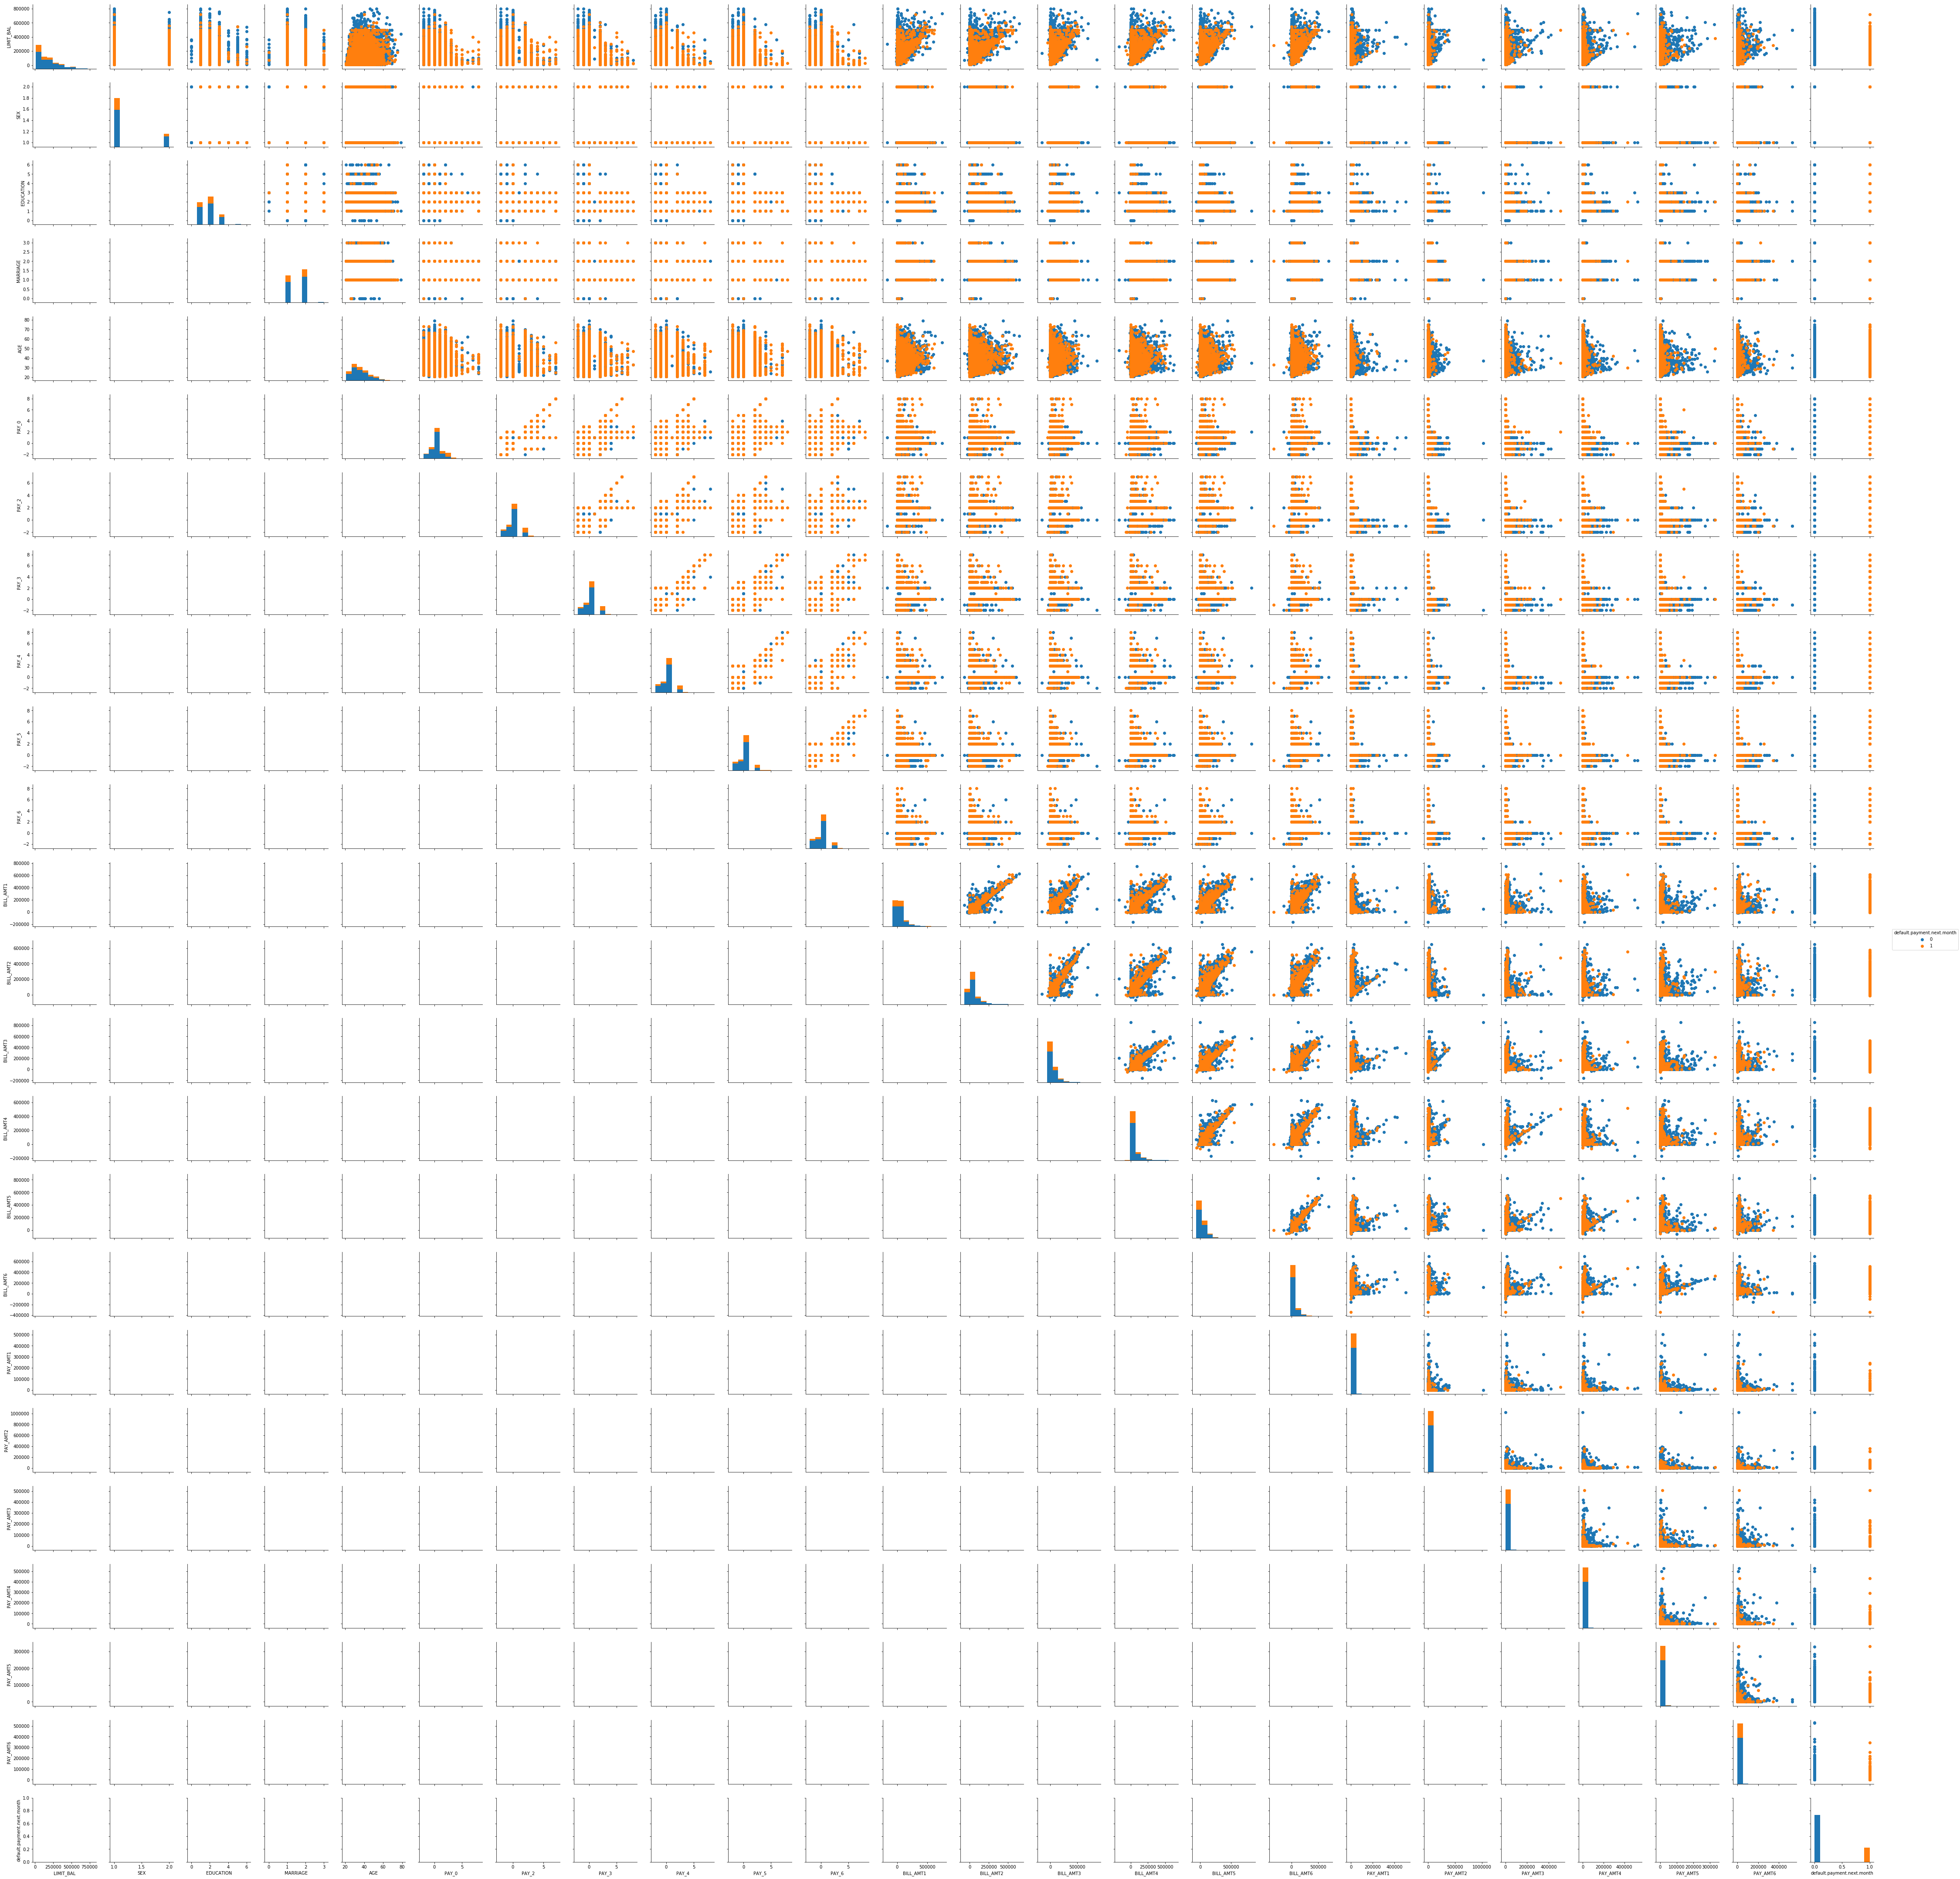

In [10]:
# Checking the distribution of data (histograms) - Download the final image to zoom in

# Observing the pairplots (scatterplots) for detecting interactions among numerical features only
# If interactions found, we can create better features (combination of more than one feature) for our models

# DEFAULTED       - Orange hue
# DID NOT DEFAULT - Blue   hue

g = sns.PairGrid(df, hue="default.payment.next.month")
g.map_upper(plt.scatter) # Upper part - showing scatterplot
g.map_diag(plt.hist) # Diagonal part - showing the Histogram 
# g.map_lower(sns.kdeplot) # Lower part - showing KDE (Kernel Density Estimate) plot -Long execution time due to KDE computation
g.add_legend()

> Could NOT find any significant interactions among numerical features

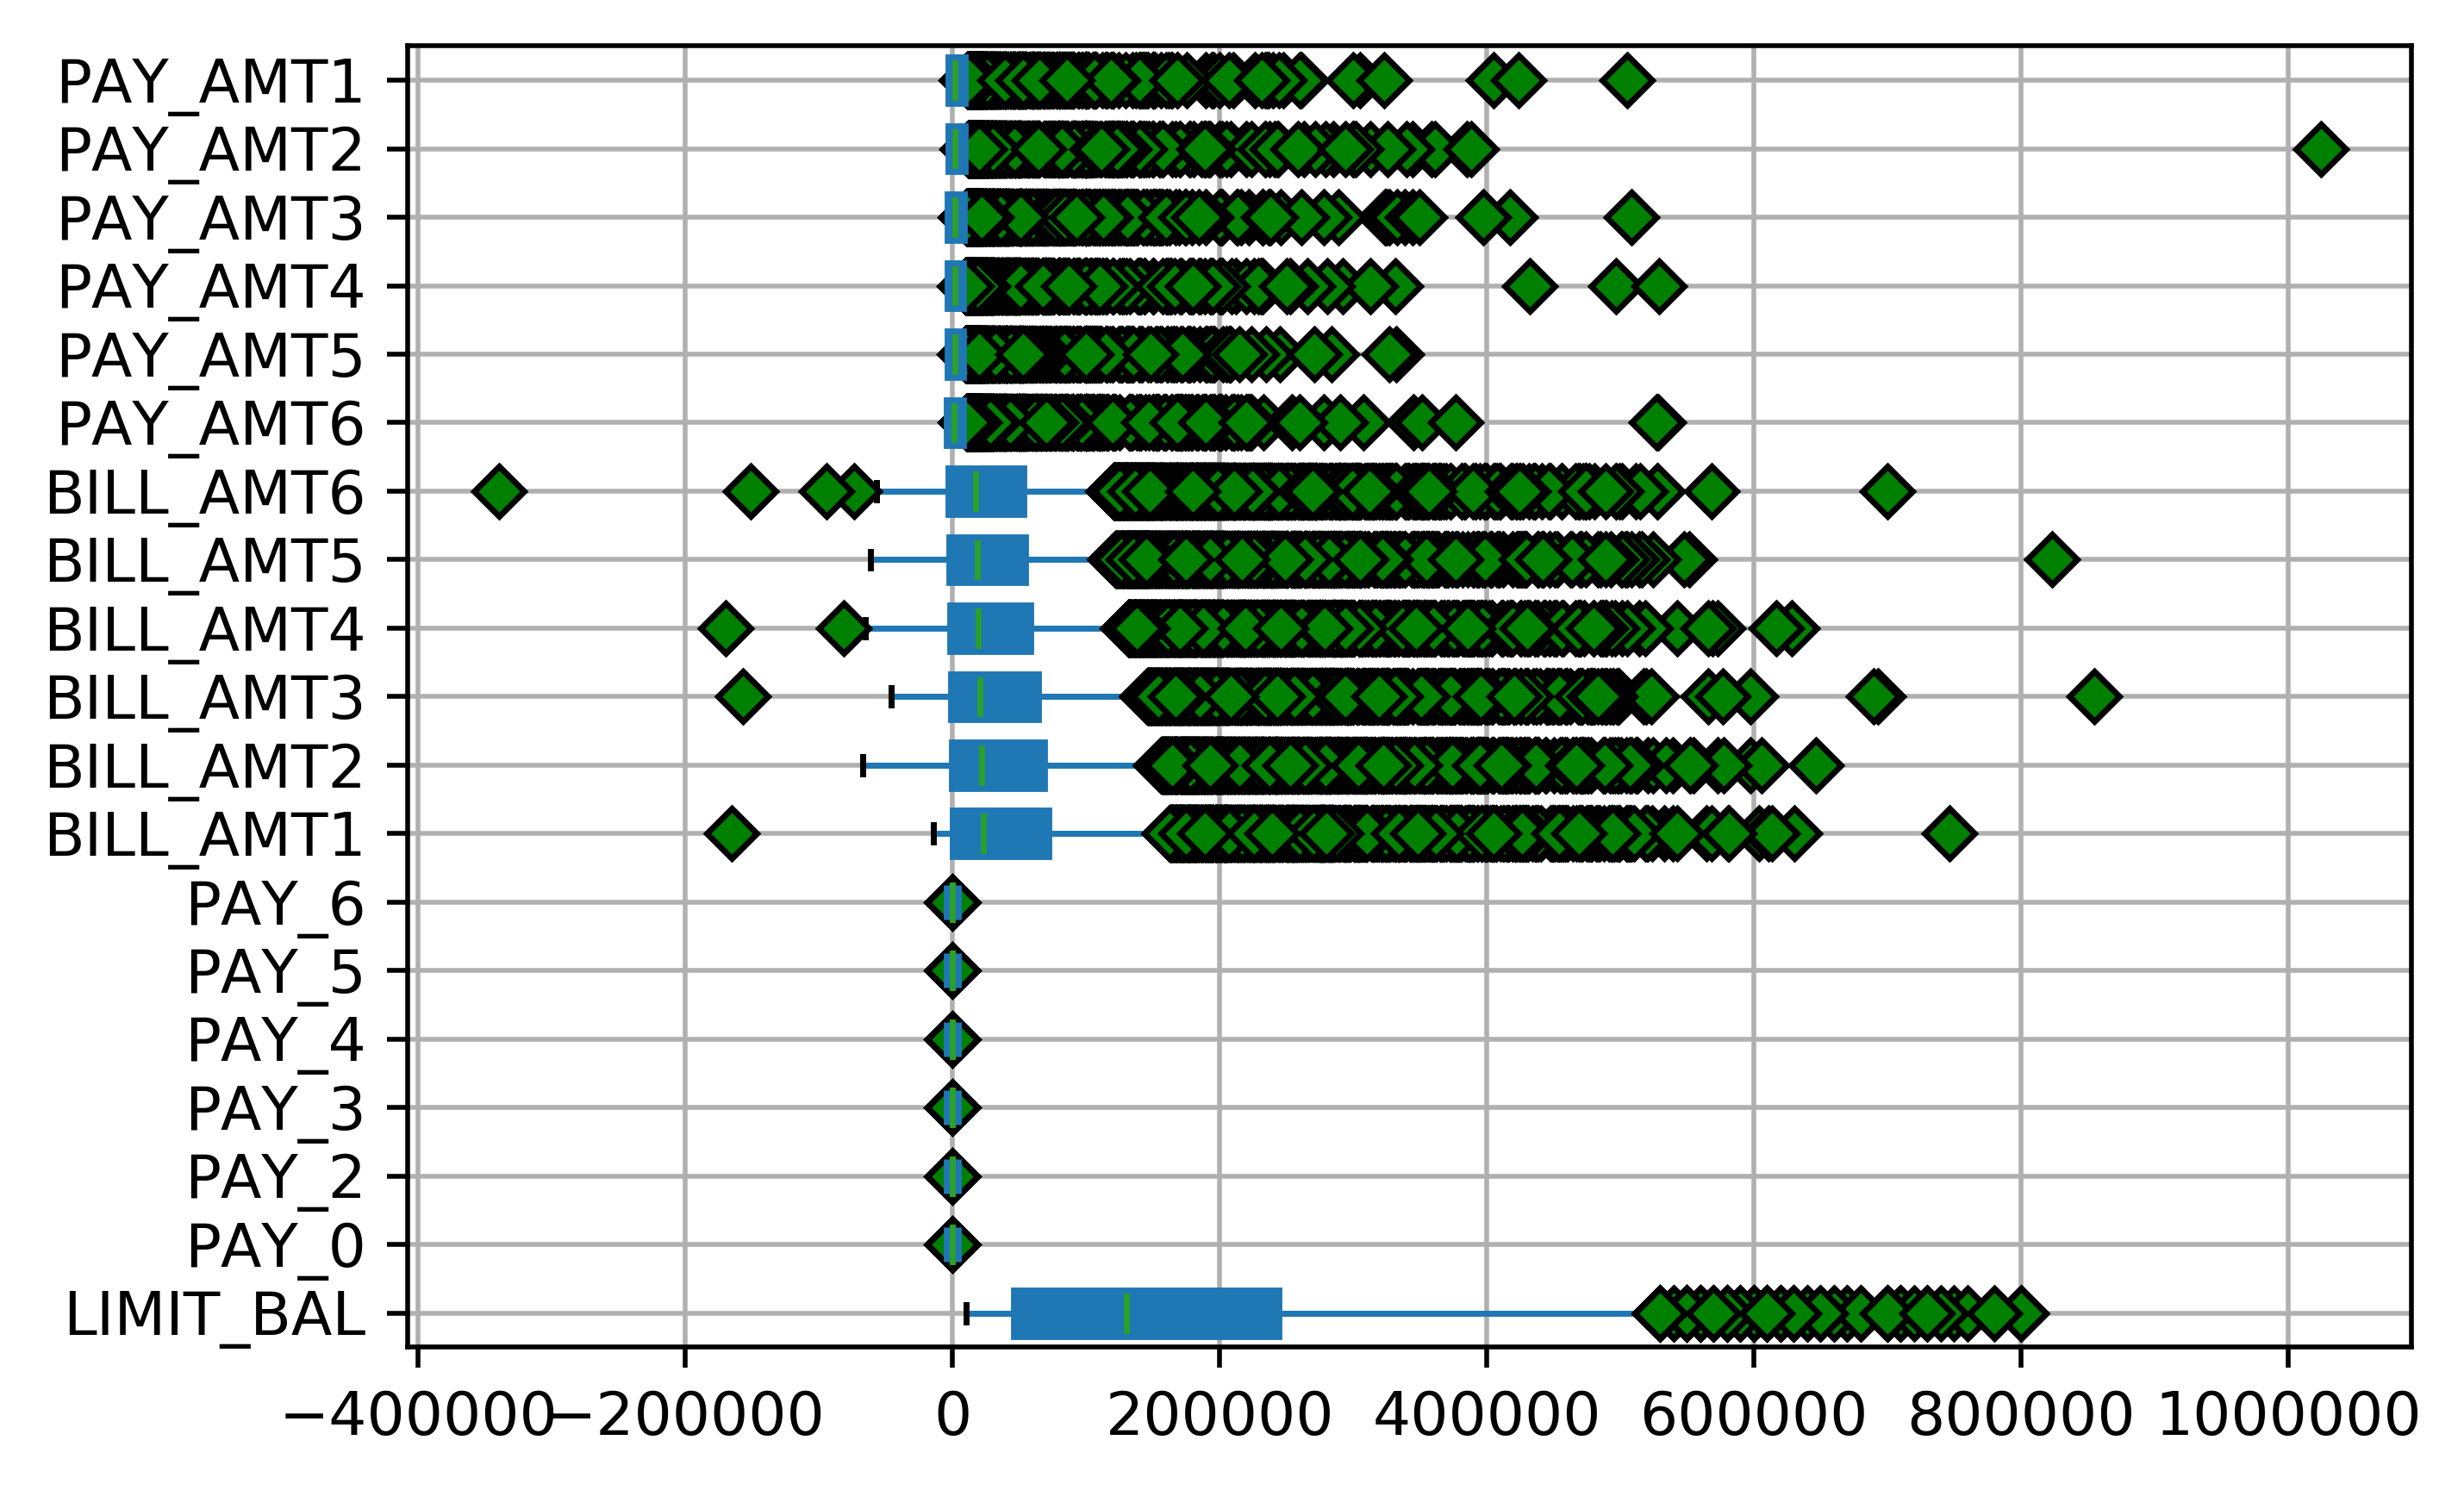

In [11]:
plt.figure(dpi = 500)
df.boxplot(column = ['LIMIT_BAL','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
                     'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                     'PAY_AMT6','PAY_AMT5','PAY_AMT4','PAY_AMT3','PAY_AMT2','PAY_AMT1'], 
           vert = False, patch_artist = True, flierprops=dict(markerfacecolor='g', marker='D'), boxprops = dict(linewidth=3))

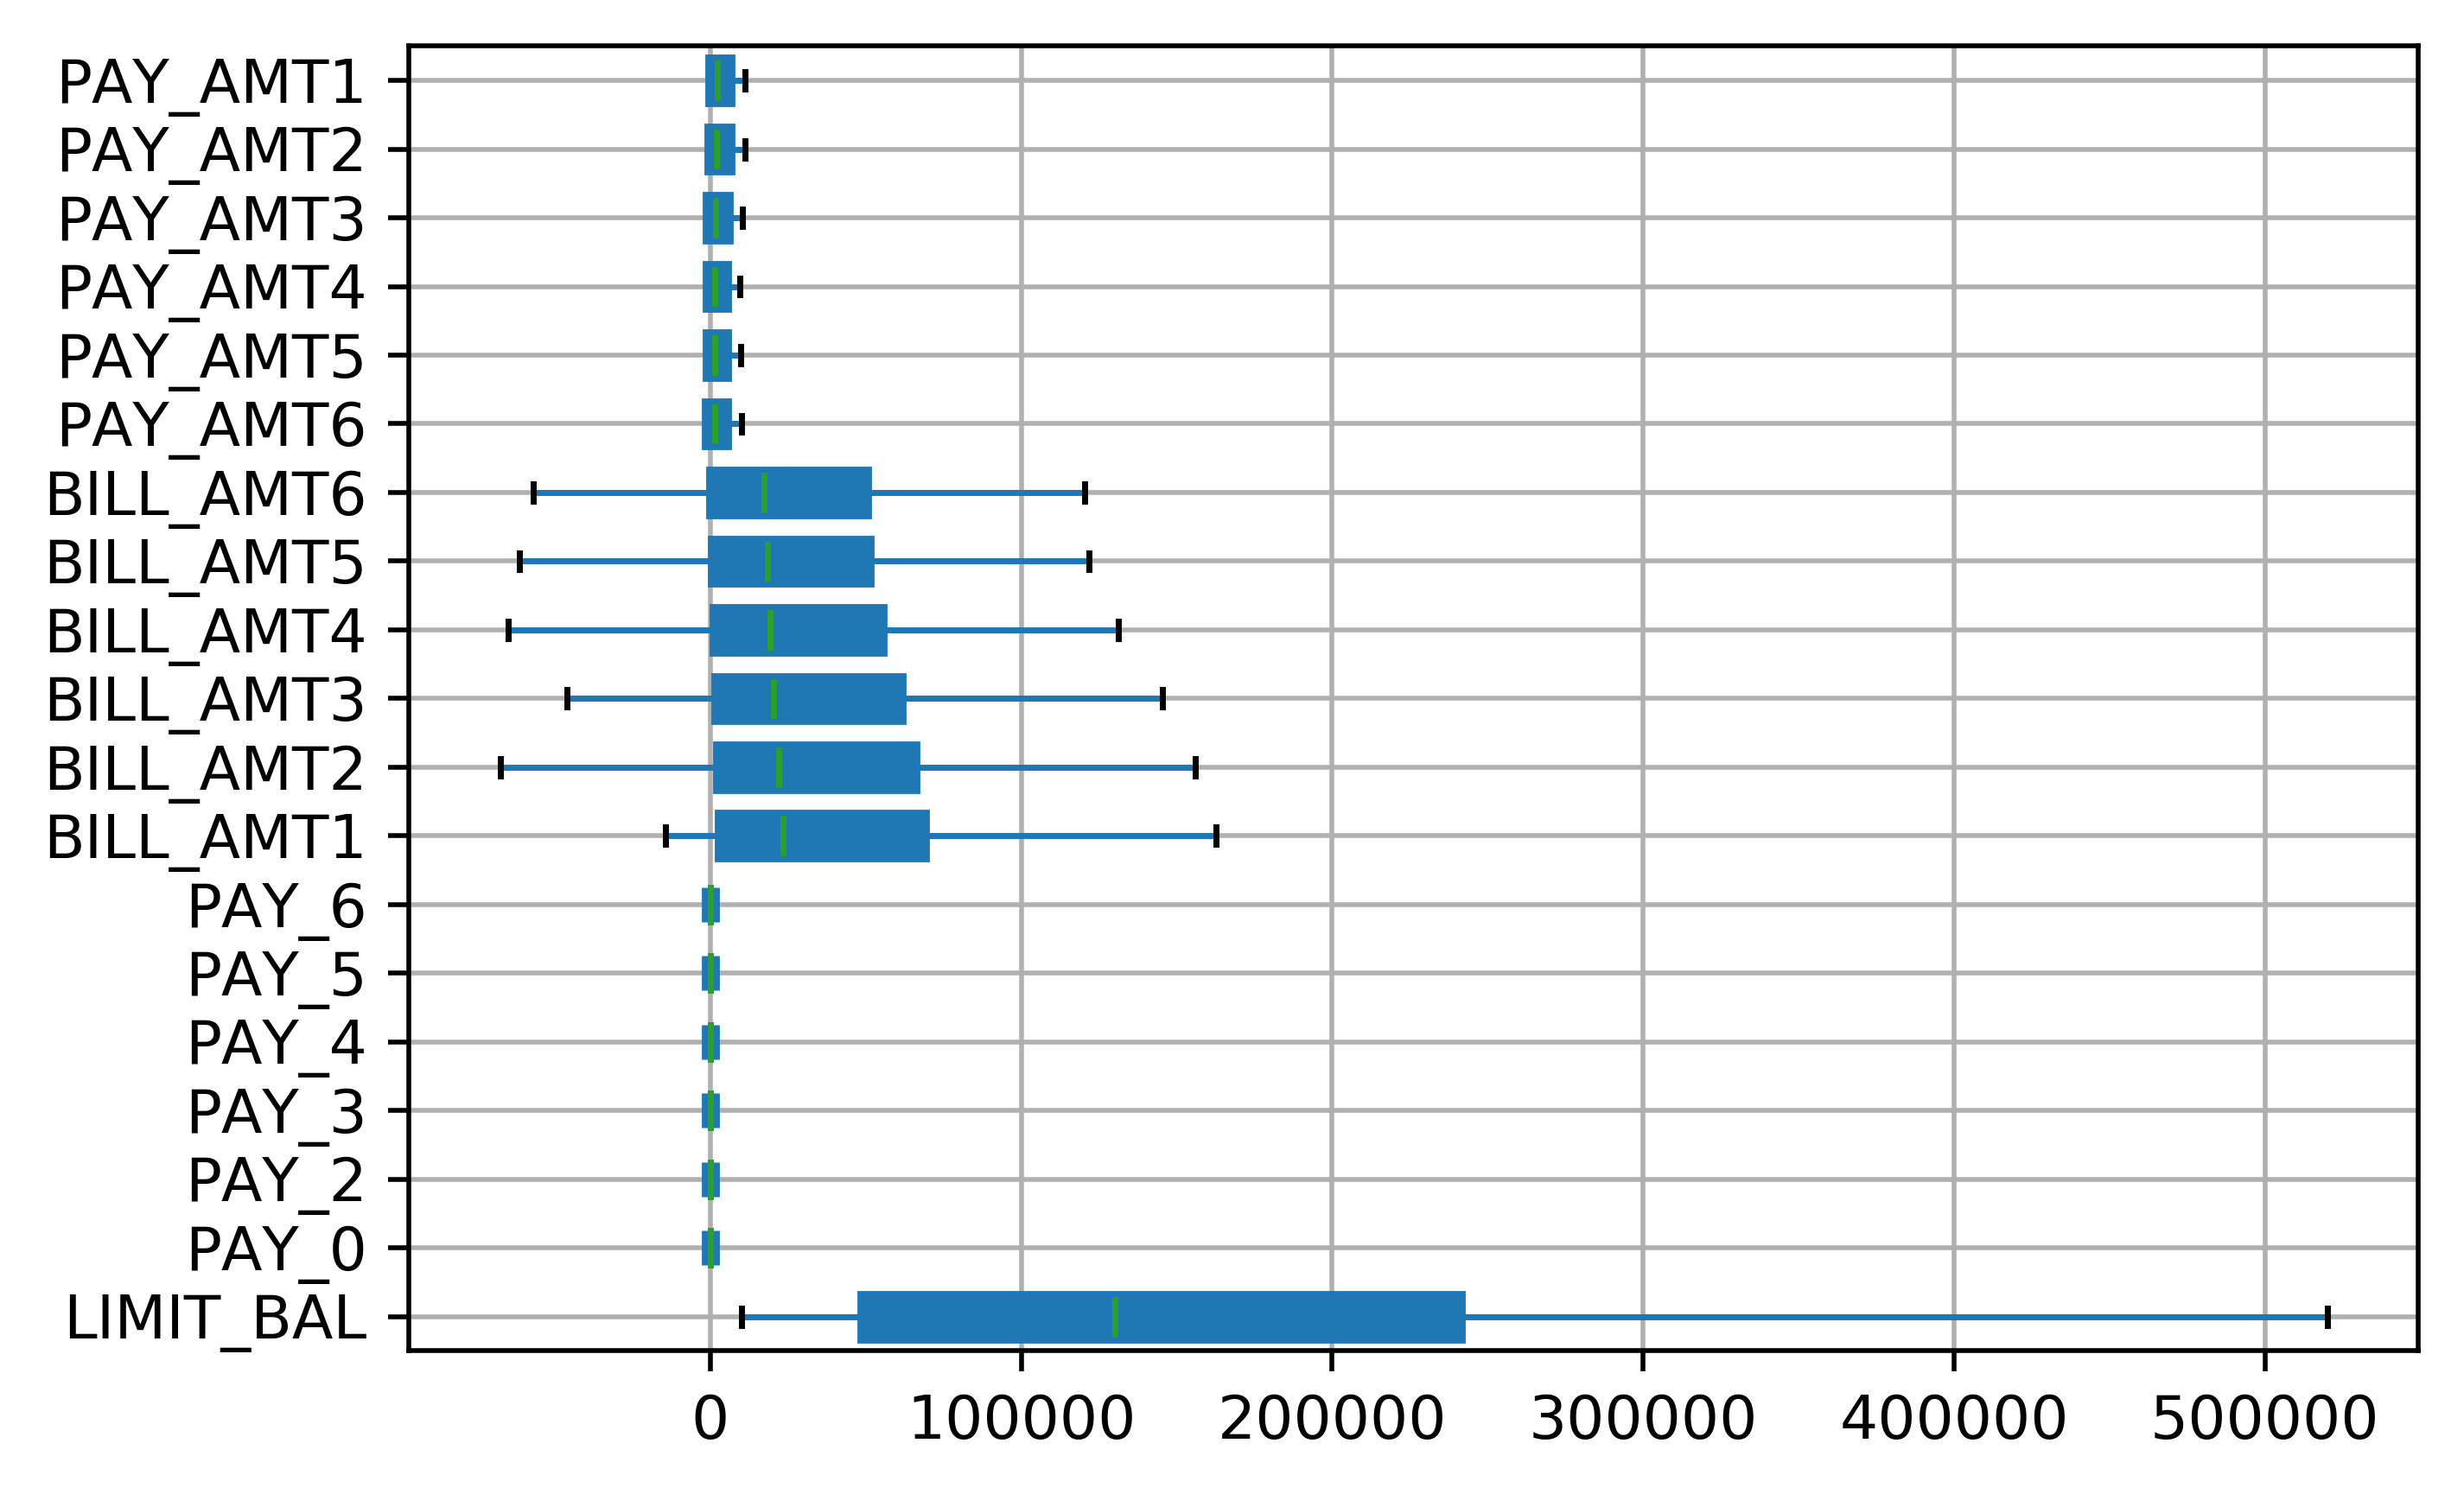

In [12]:
plt.figure(dpi = 500)
df.boxplot(column = ['LIMIT_BAL','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
                     'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                     'PAY_AMT6','PAY_AMT5','PAY_AMT4','PAY_AMT3','PAY_AMT2','PAY_AMT1'], 
                    vert = False, patch_artist = True, flierprops=dict(markerfacecolor='g', marker='D'), boxprops = dict(linewidth=3),
                    showfliers = False)

> We do see some outliers, but since it is difficult to see from the boxplot what is the exact value for the whisker, we need to use a numerical method, so we use Z-score method (Can also use IQR method)

In [13]:
# Zscore calculation for outlier removal

z = np.abs(stats.zscore(df.iloc[:,4:22].values, axis = 1))
print(type(z))
print(pd.DataFrame(z).isnull().sum().sum()) #z should not have any null values - just a sanity check
print(pd.DataFrame(z).max()) #To see max. z scores in each column
print(pd.DataFrame(z).min()) #To see min. z scores in each column

<class 'numpy.ndarray'>
0
0     4.116907
1     1.341341
2     1.341341
3     1.341341
4     1.341341
5     1.341341
6     1.341341
7     4.123106
8     3.579893
9     3.435900
10    3.652022
11    3.619644
12    4.123059
13    4.122779
14    4.123105
15    4.123078
16    4.123078
17    4.122902
dtype: float64
0     0.002915
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000116
8     0.000092
9     0.000436
10    0.000365
11    0.000769
12    0.000033
13    0.000362
14    0.000298
15    0.000734
16    0.000191
17    0.000053
dtype: float64


In [14]:
# Removing outliers using threshold of zscore = 3

# Setting threshold
threshold = 3
print(np.where(z > 3)) #This return the indexes of Rows and Columns where the threshold was > 3

# Checking how many outliers were found using this threshold
print('Total number of Outliers found using zscore threshold of 3 : ' + str(len(np.where(z > 3)[0]))) #could also have used np.where(z > 3)[1]
print('Total number of Outliers found using zscore threshold of 3.1 : ' + str(len(np.where(z > 3.1)[0])))
print('Total number of Outliers found using zscore threshold of 3.3 : ' + str(len(np.where(z > 3.3)[0]))) 

(array([    0,    14,    18, ..., 14985, 14986, 14992]), array([ 7,  0, 14, ...,  0,  7,  8]))
Total number of Outliers found using zscore threshold of 3 : 1522
Total number of Outliers found using zscore threshold of 3.1 : 1376
Total number of Outliers found using zscore threshold of 3.3 : 1154


## **Since 10% of the data is getting removed as outliers, we decide NOT to remove any Outliers and proceed and see how the model behaves! (Will revisit this!!)

In [15]:
# If we need to remove outliers we can use the below command:
# boston_df_o = boston_df_o[(z < 3).all(axis=1)]

# For now, we will build the model without correcting for dataset imbalance, and try to observe results

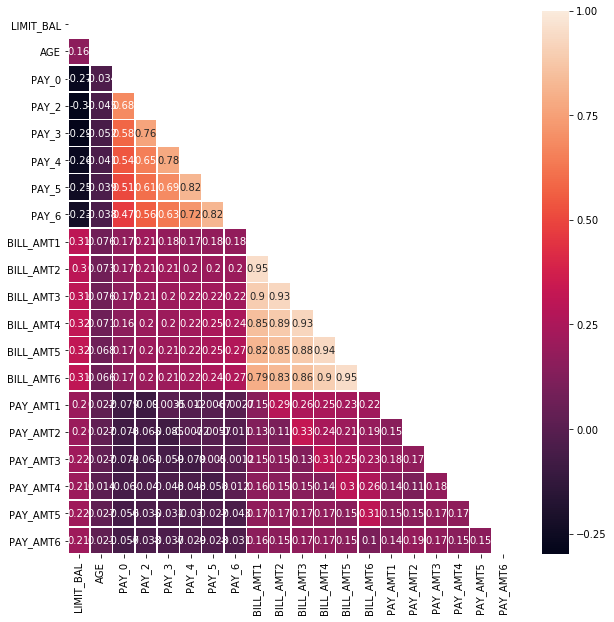

In [16]:
# C1: Observing Correlations between Numeric-Numeric features - Using Pearson's Correlation Coefficient
corr_all_input=df[df.columns].corr()
fig, ax=plt.subplots(figsize=(10,10))
# To plot a lower triangular corr matrix, use the below:
mask = np.zeros_like(corr_all_input)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_all_input, annot=True, linewidths=0.5, ax=ax, mask = mask)
plt.show()

Assuming correlation threshld of ~0.50:
> ## BILL_AMT* are correlated with each other - Makes intuitive sense as a person may spend an equal amount on the credit card every month.

> ## PAY_* are correlaed to each other - Makes intuitive sense.

In [17]:
# C2 : Observing Correlations between Categorical-Categorical features - Using Pearson's Chi-squared Null Hypothesis Test
# Condition: For the test to be effective, at least five observations are required in each cell of the contingency table - satisfied

# C2.1 Checking correlation of SEX, EDUCATION or MARRIAGE with the output default.payment.next.month- The features with
# low correlation to output can be dropped
X = df.iloc[:,1:4] 
y = df.iloc[:,23]
i = 0
for i in range(0,3):
    f_obs = pd.crosstab(index = X.iloc[:,i], columns = y)
    print('\n' + str(f_obs))
    i = i + 1
    chi2, p, dof, ex = chi2_contingency(observed = f_obs)
    print('chi-squared statistic: ' + str(chi2))
    print('p-value: ' + str(p))
    
#     chisq, p = stats.chisquare(f_obs = f_obs, axis = None) #f_exp are equally likely by default 
#     print('chi-squared statistic: ' + str(chisq))
#     print('p-value: ' + str(p))


default.payment.next.month     0     1
SEX                                   
1                           9015  2873
2                           2479   633
chi-squared statistic: 19.95129907864831
p-value: 7.943996192050907e-06

default.payment.next.month     0     1
EDUCATION                             
0                             11     0
1                           4332  1084
2                           5135  1740
3                           1824   665
4                             48     5
5                            121     8
6                             23     4
chi-squared statistic: 95.48412547413972
p-value: 2.1920283834078103e-18

default.payment.next.month     0     1
MARRIAGE                              
0                             17     2
1                           5001  1667
2                           6357  1789
3                            119    48
chi-squared statistic: 23.35351013975878
p-value: 3.4079468698017555e-05


> If p-value <= alpha: significant result, reject null hypothesis (H0), dependent

> If p-value > alpha: not significant result, fail to reject null hypothesis (H0), independent


## Since p-values for all three (SEX, EDUCATION and MARRIAGE) are very small compared to alpha = 0.05, all three are important in predicting the output "Default".

## However, based on p-values, EDUCATION is clearly the most important!!

In [18]:
# C2.2 Checking correlation between SEX, EDUCATION or MARRIAGE with each other - The features with
# high correlation to the other can be dropped to avoid multicollinearity
X = df.iloc[:,1:4]

# SEX with EDUCATION
f_obs = pd.crosstab(index = X.iloc[:,0], columns = X.iloc[:,1])
print('\n' + str(f_obs))
chi2, p, dof, ex = chi2_contingency(observed = f_obs)
print('chi-squared statistic: ' + str(chi2))
print('p-value: ' + str(p))

# SEX with MARRIAGE
f_obs = pd.crosstab(index = X.iloc[:,0], columns = X.iloc[:,2])
print('\n' + str(f_obs))
chi2, p, dof, ex = chi2_contingency(observed = f_obs)
print('chi-squared statistic: ' + str(chi2))
print('p-value: ' + str(p))

# EDUCATION with MARRIAGE
f_obs = pd.crosstab(index = X.iloc[:,1], columns = X.iloc[:,2])
print('\n' + str(f_obs))
chi2, p, dof, ex = chi2_contingency(observed = f_obs)
print('chi-squared statistic: ' + str(chi2))
print('p-value: ' + str(p))


EDUCATION  0     1     2     3   4   5   6
SEX                                       
1          8  4354  5374  1990  42  95  25
2          3  1062  1501   499  11  34   2
chi-squared statistic: 15.61278920899005
p-value: 0.015990291853052174

MARRIAGE   0     1     2    3
SEX                          
1         14  5190  6553  131
2          5  1478  1593   36
chi-squared statistic: 15.6178275941496
p-value: 0.0013580279908589604

MARRIAGE    0     1     2   3
EDUCATION                    
0           0     3     8   0
1           1  2043  3338  34
2           3  3165  3624  83
3          15  1354  1073  47
4           0    22    30   1
5           0    66    61   2
6           0    15    12   0
chi-squared statistic: 313.87011925815835
p-value: 6.710849111949636e-56


## Here, if we take an alpha = 0.05, all three SEX, EDUCATION and MARRIAGE are correlated to each other (we have to remove 2 variables) => Inferring that "Sex" is not required to predict defaults!!

## But, if we take an alpha = 0.01, SEX and EDUCATION are NOT correlated, only MARRIAGE is correlated with both SEX and EDUCATION (we can remove MARRIAGE) => Inferring that "Sex" is required to predict defaults.

In [48]:
# C3: Observing Correlations between Categorical-Numerical features - Using ANOVA?
#In one-way ANOVA, the F-statistic is this ratio:
#F = variation between sample means / variation within the samples
#If the group means are clustered close to the overall mean, their variance is low. However, if the group means are 
# spread out further from the overall mean, their variance is higher.

print('IF TWO VARIABLES HAVE p < 0.05, THEN VARIABLES ARE DEPENDENT')
#For SEX
df_numeric = pd.concat([df.iloc[:,0],df.iloc[:,4:23]],axis = 1)
for X in df_numeric.columns:
    print('For ' + X + ' with ' + 'SEX:')
    anova = ss.f_oneway(df[X],df['SEX'])
    print(anova)
    if (anova.pvalue < 0.05 and anova.statistic > 10000): #ideally, the f-statistic level is set by a complex process, but we simplify
        print("**" + X + " AND " + "SEX" + " CORRELATED**")
print("-----------------------------")

#For EDUCATION
df_numeric = pd.concat([df.iloc[:,0],df.iloc[:,4:23]],axis = 1)
for X in df_numeric.columns:
    print('For ' + X + ' with ' + 'EDUCATION:')
    anova = ss.f_oneway(df[X],df['EDUCATION'])
    print(anova)
    if (anova.pvalue < 0.05 and anova.statistic > 10000): #ideally, the f-statistic level is set by a complex process, but we simplify:
        print("**" + X + " AND " + "EDUCATION" + " CORRELATED**")
print("-----------------------------")

#For MARRIAGE
df_numeric = pd.concat([df.iloc[:,0],df.iloc[:,4:23]],axis = 1)
for X in df_numeric.columns:
    print('For ' + X + ' with ' + 'MARRIAGE:')
    anova = ss.f_oneway(df[X],df['MARRIAGE'])
    print(anova)
    if (anova.pvalue < 0.05 and anova.statistic > 10000): #ideally, the f-statistic level is set by a complex process, but we simplify:
        print("**" + X + " AND " + "MARRIAGE" + " CORRELATED**")
print("-----------------------------")

IF TWO VARIABLES HAVE p < 0.05, THEN VARIABLES ARE DEPENDENT
For LIMIT_BAL with SEX:
F_onewayResult(statistic=22647.898162865386, pvalue=0.0)
**LIMIT_BAL AND SEX CORRELATED**
For AGE with SEX:
F_onewayResult(statistic=208334.33706321602, pvalue=0.0)
**AGE AND SEX CORRELATED**
For PAY_0 with SEX:
F_onewayResult(statistic=14132.25642492042, pvalue=0.0)
**PAY_0 AND SEX CORRELATED**
For PAY_2 with SEX:
F_onewayResult(statistic=14852.417417846003, pvalue=0.0)
**PAY_2 AND SEX CORRELATED**
For PAY_3 with SEX:
F_onewayResult(statistic=15829.963288045934, pvalue=0.0)
**PAY_3 AND SEX CORRELATED**
For PAY_4 with SEX:
F_onewayResult(statistic=17757.125940426744, pvalue=0.0)
**PAY_4 AND SEX CORRELATED**
For PAY_5 with SEX:
F_onewayResult(statistic=20023.68088135064, pvalue=0.0)
**PAY_5 AND SEX CORRELATED**
For PAY_6 with SEX:
F_onewayResult(statistic=20594.09224946151, pvalue=0.0)
**PAY_6 AND SEX CORRELATED**
For BILL_AMT1 with SEX:
F_onewayResult(statistic=7326.376086536703, pvalue=0.0)
For BILL_A

## Using Thiel's U to check Categorical-Categorical correlation again

In [49]:
# Using Thiel's U to see categorical correlation between Categorical Features and Categorical output variable
# Usage: Theil’s U, also referred to as the Uncertainty Coefficient, is based on the conditional entropy between x 
# and y — or in human language, given the value of x, how many possible states does y have, and how often do they occur.
# Just like Cramer’s V, the output value is on the range of [0,1], with the same interpretations as before —
# 0 means no association and 1 is full association
# but unlike Cramer’s V, it is asymmetric, meaning U(x,y)≠U(y,x) (while V(x,y)=V(y,x), where V is Cramer’s V). 
# Using Theil’s U in the simple case above will let us find out that knowing y means we know x, but not vice-versa.

#Function code taken from Reference#5 and Reference#4
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
# End of function code

X = df.iloc[:,1:4] 
y = df.iloc[:,23]

for i in range(0,3):
    print("Theil's U for " + X.iloc[:,i].name + " with " + y.name + " is: " + str(theils_u(X.iloc[:,i],y)))

print("\nSince Thiel's U tells us that knowing x, we can predict y with a certainity (0 being min., 1 being max.), we need to check both ways:")
print("Theil's U for " + X.iloc[:,0].name + " with " + X.iloc[:,1].name + " is: " + str(theils_u(X.iloc[:,0],X.iloc[:,1])))
print("Theil's U for " + X.iloc[:,1].name + " with " + X.iloc[:,0].name + " is: " + str(theils_u(X.iloc[:,1],X.iloc[:,0])))

print("\nTheil's U for " + X.iloc[:,1].name + " with " + X.iloc[:,2].name + " is: " + str(theils_u(X.iloc[:,1],X.iloc[:,2])))
print("Theil's U for " + X.iloc[:,2].name + " with " + X.iloc[:,1].name + " is: " + str(theils_u(X.iloc[:,2],X.iloc[:,1])))

print("\nTheil's U for " + X.iloc[:,2].name + " with " + X.iloc[:,0].name + " is: " + str(theils_u(X.iloc[:,2],X.iloc[:,0])))
print("Theil's U for " + X.iloc[:,0].name + " with " + X.iloc[:,2].name + " is: " + str(theils_u(X.iloc[:,0],X.iloc[:,2])))

Theil's U for SEX with default.payment.next.month is: 0.0013481828139497148
Theil's U for EDUCATION with default.payment.next.month is: 0.0032180963031619592
Theil's U for MARRIAGE with default.payment.next.month is: 0.0010452760523953812

Since Thiel's U tells us that knowing x, we can predict y with a certainity (0 being min., 1 being max.), we need to check both ways:
Theil's U for SEX with EDUCATION is: 0.0010570313974587631
Theil's U for EDUCATION with SEX is: 0.0004902124546990646

Theil's U for EDUCATION with MARRIAGE is: 0.009037482907995815
Theil's U for MARRIAGE with EDUCATION is: 0.013257995450761903

Theil's U for MARRIAGE with SEX is: 0.0006914077836336908
Theil's U for SEX with MARRIAGE is: 0.0010162660888911072


## Observations:
> This again confirms that EDUCATION is strongly correlated with the Default, compared to SEX or MARRIAGE!

> If we know SEX we can predict EDUCATION better than EDUCATION predicting SEX
 
> If we know MARRIAGE we can predict EDUCATION better than EDUCATION predicts MARRIAGE

> If we know SEX we can predict MARRIAGE better than MARRIAGE predicts SEX

## SUMMARY of Feature Selection:

> 

## Creating Models

In [51]:
# Basic setup for Modelling

#One-Hot Encoding the Categorical Features
y = df.iloc[:,23]
X = df.iloc[:,0:23]
X_valid = df_pred
enc_col_list = ['SEX','EDUCATION','MARRIAGE']
X = X.append(X_valid)
X = pd.get_dummies(X, columns = enc_col_list)
X_valid = X.iloc[len(X)-2:len(X),:]
X = X.iloc[0:len(X)-2,:]

# Need to fix dummy variable trap for the three categorical variables above
X.drop(['SEX_1','EDUCATION_0','MARRIAGE_0'],axis = 1, inplace = True)
X_valid.drop(['SEX_1','EDUCATION_0','MARRIAGE_0'],axis = 1, inplace = True)

#Scaling training data
X_cols = X.columns
standard_scaler = StandardScaler(copy = False)
X = standard_scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = X_cols

#Scaling validation data - Validation data should be scaled separately and not with training data - to avoid contamination from training data
standard_scaler = StandardScaler(copy = False)
X_valid = standard_scaler.fit_transform(X_valid)
X_valid = pd.DataFrame(X_valid)
X_valid.columns = X_cols

X_backup = X
y_backup = y

## Should we scale the Validation data?? TBC

In [52]:
#Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

Showing performance of classifier_LR
Best parameters: {'C': 0.1, 'class_weight': 'balanced'}
Confusion Matrix: 
[[2237   74]
 [ 501  188]]
*********AUC: 0.6204192230130523
****ACCURACY: 0.8083333333333333
***PRECISION: 0.7175572519083969
******RECALL: 0.2728592162554427
****F1 SCORE: 0.4877739837196574


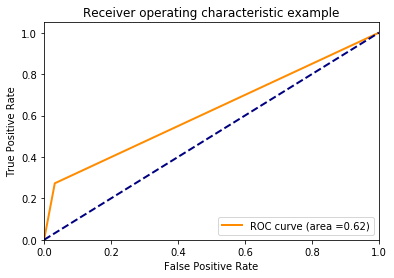

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

        0.0       0.82      0.97      0.89      2311
        1.0       0.72      0.27      0.40       689

avg / total       0.79      0.81      0.77      3000

FINAL PREDICTION BY THIS MODEL: [0. 0.]
Showing performance of classifier_KNN
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Confusion Matrix: 
[[2122  189]
 [ 434  255]]
*********AUC: 0.6441594092492584
****ACCURACY: 0.7923333333333333
***PRECISION: 0.5743243243243243
******RECALL: 0.37010159651669083
****F1 SCORE: 0.39971742640839897


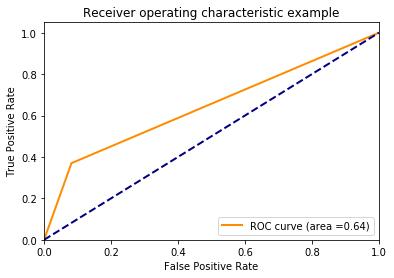

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

        0.0       0.83      0.92      0.87      2311
        1.0       0.57      0.37      0.45       689

avg / total       0.77      0.79      0.78      3000

FINAL PREDICTION BY THIS MODEL: [0. 0.]
Showing performance of classifier_SVM
Best parameters: {'C': 1.0, 'kernel': 'linear'}
Confusion Matrix: 
[[2239   72]
 [ 504  185]]
*********AUC: 0.6186748679094556
****ACCURACY: 0.808
***PRECISION: 0.7198443579766537
******RECALL: 0.26850507982583455
****F1 SCORE: 0.3568842702846804


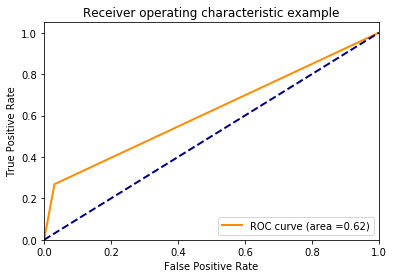

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

        0.0       0.82      0.97      0.89      2311
        1.0       0.72      0.27      0.39       689

avg / total       0.79      0.81      0.77      3000

FINAL PREDICTION BY THIS MODEL: [0. 0.]
Showing performance of classifier_NB
Best parameters: {}
Confusion Matrix: 
[[1113 1198]
 [ 136  553]]
*********AUC: 0.642111087315728
****ACCURACY: 0.5553333333333333
***PRECISION: 0.3158195316961736
******RECALL: 0.8026124818577649
****F1 SCORE: 0.4527408875641479


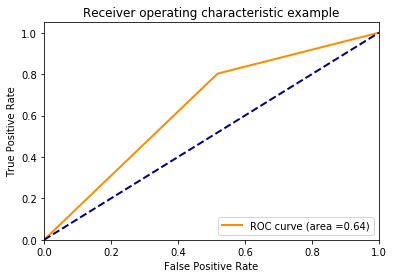

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

        0.0       0.89      0.48      0.63      2311
        1.0       0.32      0.80      0.45       689

avg / total       0.76      0.56      0.59      3000

FINAL PREDICTION BY THIS MODEL: [0. 1.]
Showing performance of classifier_RF
Best parameters: {'criterion': 'gini', 'n_estimators': 5}
Confusion Matrix: 
[[2180  131]
 [ 455  234]]
*********AUC: 0.6414686119706408
****ACCURACY: 0.8046666666666666
***PRECISION: 0.6410958904109589
******RECALL: 0.33962264150943394
****F1 SCORE: 0.4408745046467461


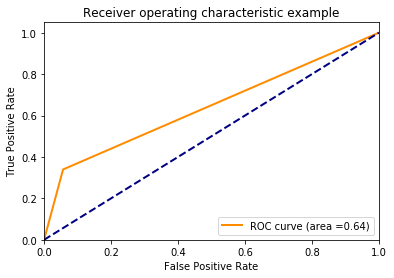

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

        0.0       0.83      0.94      0.88      2311
        1.0       0.64      0.34      0.44       689

avg / total       0.78      0.80      0.78      3000

FINAL PREDICTION BY THIS MODEL: [1. 0.]


In [53]:
# Model Type 1: 
# Using ALL features; NO Outlier Removal; NO Dataset Imbalance correction; NO Correlation correction; NO Feature Engineering

# Model training Logistic Regssion
classifier_LR = LogisticRegression(random_state = 0)

# Model training K-NN
classifier_KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# Model training SVM
classifier_SVM = SVC(C = 1.0, kernel = 'linear', random_state = 0)

# Model training Naive Bayes
classifier_NB = GaussianNB()

# Model training Random Forest
classifier_RF = RandomForestClassifier(n_estimators = 10, criterion='entropy', random_state = 0)

# Model training Decision Tree
# from sklearn.tree import DecisionTreeClassifier
# classifier_DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

# Model training Kernel SVM
# from sklearn.svm import SVC
# classifier_K_SVM = SVC(C = 1.0, kernel = 'rbf', gamma = 'auto', random_state = 0)

# Applying GridSearch Cross Validation to find out best mean accuracies of various models
y_train = np.asarray(y_train, dtype = float )
y_test = np.asarray(y_test, dtype = float )
classifiers_list = [(classifier_LR,'classifier_LR'), (classifier_KNN,'classifier_KNN'), (classifier_SVM,'classifier_SVM'),
                    (classifier_NB,'classifier_NB'), (classifier_RF,'classifier_RF')]
                   # (classifier_DT,'classifier_DT'), (classifier_K_SVM,'classifier_K_SVM')
# Grid-Search
Grid_srch_parameters_list = [[{'C': [0.1, 1.0, 10, 100], 'class_weight': ['balanced']}],
                            [{'n_neighbors':[3,5],'weights':['uniform'],'p':[1]}],
                            [{'C':[0.1, 1.0],'kernel':['linear']}],
                            [{}],
                            [{'n_estimators':[5,10,20],'criterion':['entropy','gini']}]]
                            # [{'C':[0.1, 0.5, 1.0, 10, 100],'kernel':['rbf','sigmoid'],'gamma':['auto',0.1,1.0,10,100]}] #Kernel-SVM
                            # [{'criterion':['entropy','gini']}] #Decision Tree

# Function code taken from Reference #6
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area ={0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show();
#End of Function

#Custom function created by me for Scoring - This is needed because GridSearchCV metrics were behaving erratically
#Assumption - the Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp
def custom_precision_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))
def custom_recall_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))
def custom_f1_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ( 2*(tp/(tp+fp))*(tp/(tp+fn))/((tp/(tp+fp))+(tp/(tp+fn))) )

#GridSearchCV custom scorer definition
score_func = make_scorer(custom_f1_score, greater_is_better=True)
    
i, length = 0, len(classifiers_list) + 1
for clf in classifiers_list:
    # Fitting classifier to training data
    clf[0].fit(X_train, y_train)
    # Predicting output
    y_pred = clf[0].predict(X_test)
    grid_search = GridSearchCV(estimator = clf[0], param_grid = Grid_srch_parameters_list[i], scoring = score_func,cv = 10)
    grid_search = grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    # Calculating mean accuracy using k-fold
    # accuracies = cross_val_score(estimator = clf[0], X = X_train_initial, y = y_train_initial, cv = 10)
    # mean_accuracy = accuracies.mean()
    print('Showing performance of ' + clf[1])
    print('Best parameters: ' + str(grid_search.best_params_))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n" + str(cm)) #Actual on the Left, Pred at the Top
    print("*********AUC: " + str(roc_auc_score(y_test, y_pred)))
    print("****ACCURACY: " + str(custom_accuracy_score(y_test, y_pred))) 
    print("***PRECISION: " + str(custom_precision_score(y_test, y_pred)))
    print("******RECALL: " + str(custom_recall_score(y_test, y_pred)))
    print("****F1 SCORE: " + str(grid_search.best_score_))
    plot_roc(y_test, y_pred)
    print("CLASSIFICATION REPORT: \n" + str(classification_report(y_test, y_pred)))
    print("FINAL PREDICTION BY THIS MODEL: " + str(grid_search.predict(X_valid)))
    print("---------------------------------------------------------------------")
    i=i+1

In [54]:
# Model Type 2: Correlation correction
# Using SOME features; NO Outlier Removal; NO Dataset Imbalance correction; NO Feature Engineering

# Correcting for Correlation: Keeping only 1 feature for PAY_* and only 1 feature for BILL_AMT_*
X = X_backup
y = y_backup

X.drop(['PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], 
       axis = 1, inplace = True)
X_valid.drop(['PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], 
       axis = 1, inplace = True)

Showing performance of classifier_LR
Best parameters: {'C': 10, 'class_weight': 'balanced'}
Confusion Matrix: 
[[2234   68]
 [ 525  173]]
*********AUC: 0.609155736011292
****ACCURACY: 0.8023333333333333
***PRECISION: 0.7178423236514523
******RECALL: 0.24785100286532952
****F1 SCORE: 0.48342180521059813


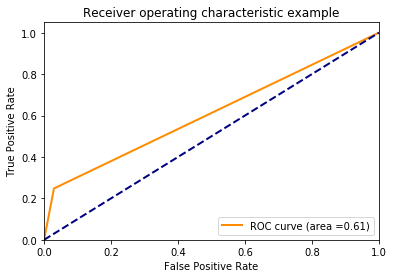

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.81      0.97      0.88      2302
          1       0.72      0.25      0.37       698

avg / total       0.79      0.80      0.76      3000

FINAL PREDICTION BY THIS MODEL: [0 1]
Showing performance of classifier_KNN
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Confusion Matrix: 
[[2102  200]
 [ 446  252]]
*********AUC: 0.6370752727788718
****ACCURACY: 0.7846666666666666
***PRECISION: 0.5575221238938053
******RECALL: 0.36103151862464183
****F1 SCORE: 0.4133336143460458


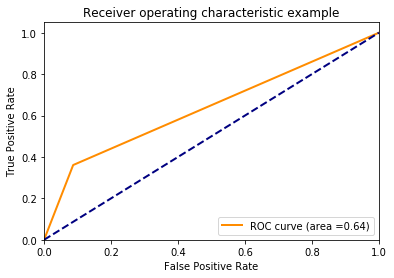

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.82      0.91      0.87      2302
          1       0.56      0.36      0.44       698

avg / total       0.76      0.78      0.77      3000

FINAL PREDICTION BY THIS MODEL: [0 0]
Showing performance of classifier_SVM
Best parameters: {'C': 1.0, 'kernel': 'linear'}
Confusion Matrix: 
[[2297    5]
 [ 681   17]]
*********AUC: 0.5110916382664632
****ACCURACY: 0.7713333333333333
***PRECISION: 0.7727272727272727
******RECALL: 0.024355300859598854
****F1 SCORE: 0.07247499811471156


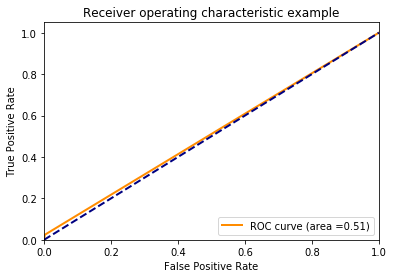

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.77      1.00      0.87      2302
          1       0.77      0.02      0.05       698

avg / total       0.77      0.77      0.68      3000

FINAL PREDICTION BY THIS MODEL: [0 0]
Showing performance of classifier_NB
Best parameters: {}
Confusion Matrix: 
[[ 427 1875]
 [  44  654]]
*********AUC: 0.5612268141070802
****ACCURACY: 0.36033333333333334
***PRECISION: 0.2586002372479241
******RECALL: 0.9369627507163324
****F1 SCORE: 0.4039607277060473


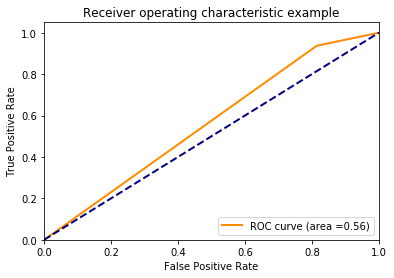

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.91      0.19      0.31      2302
          1       0.26      0.94      0.41       698

avg / total       0.76      0.36      0.33      3000

FINAL PREDICTION BY THIS MODEL: [0 0]
Showing performance of classifier_RF
Best parameters: {'criterion': 'entropy', 'n_estimators': 20}
Confusion Matrix: 
[[2164  138]
 [ 477  221]]
*********AUC: 0.6283355198793126
****ACCURACY: 0.795
***PRECISION: 0.6155988857938719
******RECALL: 0.3166189111747851
****F1 SCORE: 0.4445556194721112


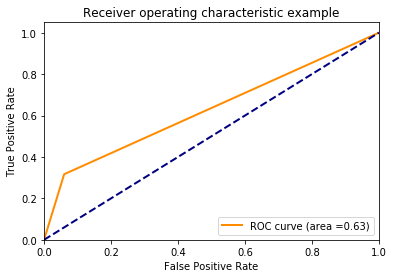

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.82      0.94      0.88      2302
          1       0.62      0.32      0.42       698

avg / total       0.77      0.80      0.77      3000

FINAL PREDICTION BY THIS MODEL: [0 0]


In [55]:
#Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

#Model Training and Evaluation
i, length = 0, len(classifiers_list) + 1
for clf in classifiers_list:
    # Fitting classifier to training data
    clf[0].fit(X_train, y_train)
    # Predicting output
    y_pred = clf[0].predict(X_test)
    grid_search = GridSearchCV(estimator = clf[0], param_grid = Grid_srch_parameters_list[i], scoring = score_func,cv = 10)
    grid_search = grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    # Calculating mean accuracy using k-fold
    # accuracies = cross_val_score(estimator = clf[0], X = X_train_initial, y = y_train_initial, cv = 10)
    # mean_accuracy = accuracies.mean()
    print('Showing performance of ' + clf[1])
    print('Best parameters: ' + str(grid_search.best_params_))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n" + str(cm)) #Actual on the Left, Pred at the Top
    print("*********AUC: " + str(roc_auc_score(y_test, y_pred)))
    print("****ACCURACY: " + str(custom_accuracy_score(y_test, y_pred))) 
    print("***PRECISION: " + str(custom_precision_score(y_test, y_pred)))
    print("******RECALL: " + str(custom_recall_score(y_test, y_pred)))
    print("****F1 SCORE: " + str(grid_search.best_score_))
    plot_roc(y_test, y_pred)
    print("CLASSIFICATION REPORT: \n" + str(classification_report(y_test, y_pred)))
    print("FINAL PREDICTION BY THIS MODEL: " + str(grid_search.predict(X_valid)))
    print("---------------------------------------------------------------------")
    i=i+1

Showing performance of classifier_LR
Best parameters: {'C': 1.0, 'class_weight': 'balanced'}
Confusion Matrix: 
[[2206   77]
 [ 524  193]]
*********AUC: 0.6177247877251727
****ACCURACY: 0.7996666666666666
***PRECISION: 0.7148148148148148
******RECALL: 0.2691771269177127
****F1 SCORE: 0.48875958807010456


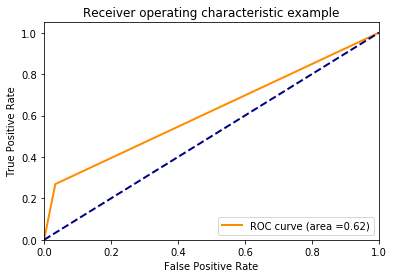

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.81      0.97      0.88      2283
          1       0.71      0.27      0.39       717

avg / total       0.79      0.80      0.76      3000

FINAL PREDICTION BY THIS MODEL: [0 1]
---------------------------------------------------------------------
Showing performance of classifier_KNN
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Confusion Matrix: 
[[2080  203]
 [ 478  239]]
*********AUC: 0.6222076215505913
****ACCURACY: 0.773
***PRECISION: 0.5407239819004525
******RECALL: 0.3333333333333333
****F1 SCORE: 0.42002157273560115


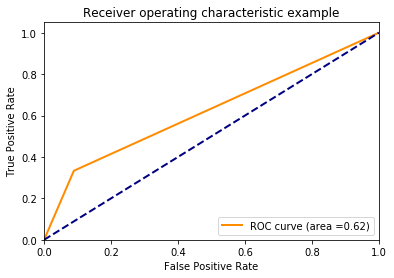

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.81      0.91      0.86      2283
          1       0.54      0.33      0.41       717

avg / total       0.75      0.77      0.75      3000

FINAL PREDICTION BY THIS MODEL: [0 0]
---------------------------------------------------------------------
Showing performance of classifier_SVM
Best parameters: {'C': 1.0, 'kernel': 'linear'}
Confusion Matrix: 
[[2263   20]
 [ 673   44]]
*********AUC: 0.5263032015790718
****ACCURACY: 0.769
***PRECISION: 0.6875
******RECALL: 0.061366806136680614
****F1 SCORE: 0.07559808837884743


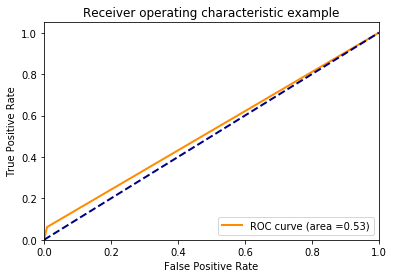

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.77      0.99      0.87      2283
          1       0.69      0.06      0.11       717

avg / total       0.75      0.77      0.69      3000

FINAL PREDICTION BY THIS MODEL: [0 0]
---------------------------------------------------------------------
Showing performance of classifier_NB
Best parameters: {}
Confusion Matrix: 
[[ 434 1849]
 [  49  668]]
*********AUC: 0.5608802189001112
****ACCURACY: 0.36733333333333335
***PRECISION: 0.2653953118792213
******RECALL: 0.9316596931659693
****F1 SCORE: 0.3995846965464365


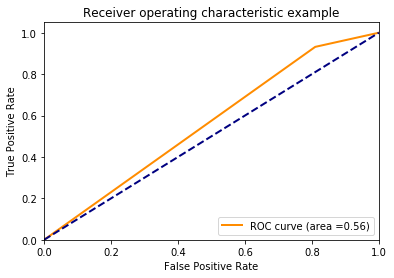

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.90      0.19      0.31      2283
          1       0.27      0.93      0.41       717

avg / total       0.75      0.37      0.34      3000

FINAL PREDICTION BY THIS MODEL: [0 0]
---------------------------------------------------------------------
Showing performance of classifier_RF
Best parameters: {'criterion': 'gini', 'n_estimators': 20}
Confusion Matrix: 
[[2162  121]
 [ 478  239]]
*********AUC: 0.6401664476565921
****ACCURACY: 0.8003333333333333
***PRECISION: 0.6638888888888889
******RECALL: 0.3333333333333333
****F1 SCORE: 0.4297025638316767


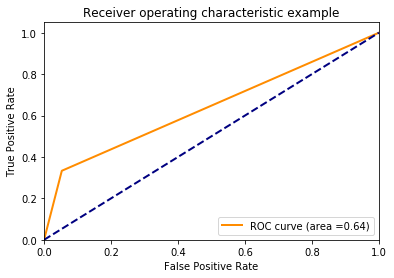

CLASSIFICATION REPORT: 
             precision    recall  f1-score   support

          0       0.82      0.95      0.88      2283
          1       0.66      0.33      0.44       717

avg / total       0.78      0.80      0.77      3000

FINAL PREDICTION BY THIS MODEL: [0 0]
---------------------------------------------------------------------


In [58]:
# Model Type 3: Multi-Correlation correction, and removing "SEX"
# Using SOME features; NO Outlier Removal; NO Dataset Imbalance correction; NO Feature Engineering

X.drop(['SEX_2'], axis = 1, inplace = True)
X_valid.drop(['SEX_2'], axis = 1, inplace = True)

#Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

#Model Training and Evaluation
i, length = 0, len(classifiers_list) + 1
for clf in classifiers_list:
    # Fitting classifier to training data
    clf[0].fit(X_train, y_train)
    # Predicting output
    y_pred = clf[0].predict(X_test)
    grid_search = GridSearchCV(estimator = clf[0], param_grid = Grid_srch_parameters_list[i], scoring = score_func,cv = 10)
    grid_search = grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    # Calculating mean accuracy using k-fold
    # accuracies = cross_val_score(estimator = clf[0], X = X_train_initial, y = y_train_initial, cv = 10)
    # mean_accuracy = accuracies.mean()
    print('Showing performance of ' + clf[1])
    print('Best parameters: ' + str(grid_search.best_params_))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n" + str(cm)) #Actual on the Left, Pred at the Top
    print("*********AUC: " + str(roc_auc_score(y_test, y_pred)))
    print("****ACCURACY: " + str(custom_accuracy_score(y_test, y_pred))) 
    print("***PRECISION: " + str(custom_precision_score(y_test, y_pred)))
    print("******RECALL: " + str(custom_recall_score(y_test, y_pred)))
    print("****F1 SCORE: " + str(grid_search.best_score_))
    plot_roc(y_test, y_pred)
    print("CLASSIFICATION REPORT: \n" + str(classification_report(y_test, y_pred)))
    print("FINAL PREDICTION BY THIS MODEL: " + str(grid_search.predict(X_valid)))
    print("---------------------------------------------------------------------")
    i=i+1

In [ ]:
# Correcting for dataset imbalance
# There are many options available for correcting the class imbalance, however, since we have very less data,
# any oversampling technique would suit best. So, we go with SMOTE for now:


Performance metrics suitable for this problem:
1. Confusion Matrix
2. Recall
3. Precision
4. F1 score
5. ROC curve??
6. Kappa? (better than accuracy)

Personal ques. to explore:
    1. How to detect interactions between Categorical and Numerical features? - eg. Numerical-Numerical has a*b 
    as a significant feature. Can we have a feature that says (If A=Male)*Salary can be a good feature?

In [ ]:
References:
    1. https://seaborn.pydata.org/generated/seaborn.heatmap.html
    2. http://www.insightsbot.com/blog/2AeuRL/chi-square-feature-selection-in-python
    3. https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
    4. https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    5. https://github.com/shakedzy/dython/blob/master/dython/nominal.py
    6. https://stackoverflow.com/questions/47569394/the-graph-of-this-roc-curve-looks-strange-sklearn-svc
    7. http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test
    8. http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-16_23.html
        
        